**This notebook is used to study the effect of the calibration period Length  on the validation performance using 50 random Stations in the CAMELS-FR dataset.**

**Objective:**
Analyze the impact of calibration period length on model performance for **50 RANDOMLY selected stations**.

### Fixed Elements:
- **Validation period**: 2016-01-01 to 2020-12-31 (5 years, FIXED)
- **Station list**: 50 stations selected randomly (SAME random seed for reproducibility)
- **Model**: d-HyMoLAP

### Variable Element:
- **Calibration period**: Varies from 2 to 15 years
  - 2 years: 2014-01-01 to 2015-12-31
  - 3 years: 2013-01-01 to 2015-12-31
  - 4 years: 2012-01-01 to 2015-12-31
  - 5 years: 2011-01-01 to 2015-12-31
  - 6 years: 2010-01-01 to 2015-12-31
  - 7 years: 2009-01-01 to 2015-12-31
  - ...
  - 15 years: 2001-01-01 to 2015-12-31

  **AUTHOR:** Lionel Cedric Gohouede


---
## 1. Setup and Imports

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from google.colab import drive
import csv
import random

print("✓ Libraries imported")

✓ Libraries imported


---
## 2. Mount Google Drive and Load RANDOM Stations

In [ ]:
# Mount Google Drive
drive.mount("/content/drive")

print("✓ Google Drive mounted")

Mounted at /content/drive
✓ Google Drive mounted


In [ ]:
# Load previous results
Path = "/content/drive/MyDrive/Colab Notebooks/Data"
results_file = f"{Path}/dHyMoLAP_Simulation_Data_CAMELS_FR.csv"

df_results = pd.read_csv(results_file)

print(f"Loaded {len(df_results)} stations from previous results")
print(f"\nFirst few rows:")
print(df_results['station_id'].head())

Loaded 549 stations from previous results

First few rows:
0    A105003001
1    A107020001
2    A112020001
3    A140202001
4    A202030001
Name: station_id, dtype: object


In [ ]:
# Select 50 RANDOM stations
# IMPORTANT: Set random seed for reproducibility
RANDOM_SEED = 42  # Change this number to get different random samples

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Get all available station IDs
all_station_ids = df_results['station_id'].tolist()

# Randomly sample 50 stations
ID_RANDOM_STATIONS = random.sample(all_station_ids, 50)

# Get statistics for selected stations
df_random50 = df_results[df_results['station_id'].isin(ID_RANDOM_STATIONS)]

print(f"\n{'='*70}")
print(f"SELECTED 50 RANDOM STATIONS")
print(f"{'='*70}")
print(f"Random seed: {RANDOM_SEED}")
print(f"\nNumber of stations: {len(ID_RANDOM_STATIONS)}")
print(f"\nNSE_val statistics:")
print(f"  Mean: {df_random50['NSE_val'].mean():.3f}")
print(f"  Median: {df_random50['NSE_val'].median():.3f}")
print(f"  Std: {df_random50['NSE_val'].std():.3f}")
print(f"  Range: [{df_random50['NSE_val'].min():.3f}, {df_random50['NSE_val'].max():.3f}]")

print(f"\nFirst 10 randomly selected stations:")
print(df_random50[['station_id', 'NSE_val', 'RMSE_val']].head(10).to_string(index=False))

print(f"\nStation IDs:")
print(ID_RANDOM_STATIONS)

# Save the random selection for reproducibility
try:
    with open(f'{Path}/ID_RANDOM_STATIONS_seed{RANDOM_SEED}.txt', 'w') as f:
        f.write(f"# Random seed: {RANDOM_SEED}\n")
        for station_id in ID_RANDOM_STATIONS:
            f.write(f"{station_id}\n")
    print(f"\n✓ Random station IDs saved to ID_RANDOM_STATIONS_seed{RANDOM_SEED}.txt")
except:
    pass


SELECTED 50 RANDOM STATIONS
Random seed: 42

Number of stations: 50

NSE_val statistics:
  Mean: 0.670
  Median: 0.699
  Std: 0.152
  Range: [-0.005, 0.874]

First 10 randomly selected stations:
station_id  NSE_val  RMSE_val
A212020002    0.828     0.779
A550061001    0.791    29.745
A615103001    0.830     5.716
A764201001    0.544     4.761
A850061001    0.832    62.318
B128201001    0.683     4.641
B222001001    0.745    18.815
F453000101    0.234     1.263
H010002001    0.759     5.318
H020302002    0.792     1.694

Station IDs:
['H512234001', 'A550061001', 'L231301001', 'K222303001', 'K053000101', 'H742371001', 'H425042010', 'H206201001', 'U012401001', 'A850061001', 'A764201001', 'H303000201', 'J843301002', 'K128481001', 'X001501001', 'A615103001', 'J451542001', 'S222461001', 'J863241001', 'U230521001', 'L403301001', 'A212020002', 'J032301001', 'O149433001', 'I722202001', 'J797301001', 'O074404001', 'H248201001', 'O839431001', 'H325041010', 'O505501001', 'O234401001', 'K409401001

---
## 3. Install and Load CAMELS-FR Data

In [ ]:
# Install aqua-fetch if needed
!pip install aqua-fetch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.1/289.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
from aqua_fetch import RainfallRunoff

# Initialize with CAMELS_FR dataset
rr = RainfallRunoff("CAMELS_FR")

print("✓ RainfallRunoff initialized")

/usr/local/lib/python3.12/dist-packages/aqua_fetch/rr/utils.py:127: UserWarning: netCDF4 module is not installed. Please install it to save data in netcdf format
  warnings.warn(msg, UserWarning)


downloading 6 files to /usr/local/lib/python3.12/dist-packages/aqua_fetch/data/CAMELS/CAMELS_FR
downloading ADDITIONAL_LICENSES.zip
0% of 0.07 MB downloaded
100% of 0.07 MB downloaded
downloading CAMELS_FR_attributes.zip
0% of 9.88 MB downloaded
100% of 9.88 MB downloaded
downloading CAMELS_FR_geography.zip
0% of 1.45 MB downloaded
100% of 1.45 MB downloaded
downloading CAMELS_FR_time_series.zip
0% of 361.39 MB downloaded
20% of 361.39 MB downloaded
40% of 361.39 MB downloaded
60% of 361.39 MB downloaded
80% of 361.39 MB downloaded
100% of 361.39 MB downloaded
downloading README.md
0% of 0.01 MB downloaded
100% of 0.01 MB downloaded
downloading CAMELS-FR_description.ods
0% of 0.05 MB downloaded
100% of 0.05 MB downloaded
unzipping files in /usr/local/lib/python3.12/dist-packages/aqua_fetch/data/CAMELS/CAMELS_FR
unzipping CAMELS_FR_attributes.zip to CAMELS_FR_attributes
unzipping CAMELS_FR_geography.zip to CAMELS_FR_geography
unzipping CAMELS_FR_time_series.zip to CAMELS_FR_time_series


In [ ]:
# Fetch data
meta, ds = rr.fetch()

print("✓ Data fetched")
print(ds)

Read 654 stations for 22 dyn features in 59.73 seconds with 2 cpus.
✓ Data fetched
<xarray.Dataset> Size: 2GB
Dimensions:           (time: 18993, dynamic_features: 22)
Coordinates:
  * time              (time) datetime64[ns] 152kB 1970-01-01 ... 2021-12-31
  * dynamic_features  (dynamic_features) object 176B 'q_cms_obs' ... 'airtemp...
Data variables: (12/654)
    A105003001        (time, dynamic_features) float64 3MB 1.65e+03 ... 13.4
    A107020001        (time, dynamic_features) float64 3MB nan nan ... 4.1 13.3
    A112020001        (time, dynamic_features) float64 3MB 1.04e+03 ... 13.4
    A116003002        (time, dynamic_features) float64 3MB nan nan ... 4.3 13.3
    A140202001        (time, dynamic_features) float64 3MB nan nan ... 6.8 12.4
    A202030001        (time, dynamic_features) float64 3MB nan nan ... 7.1 13.2
    ...                ...
    Y661401001        (time, dynamic_features) float64 3MB 860.0 0.441 ... 14.3
    Y781000101        (time, dynamic_features) float64 3

---
## 4. Data Preparation

In [ ]:
# Select extended period to include all calibration possibilities
# Need data from 2001 to 2020
ds_extended = ds.sel(time=slice("2001-01-01", "2020-12-31"))

print(f"Time range: {ds_extended['time'].values[0]} to {ds_extended['time'].values[-1]}")
print(f"\nAnalyzing {len(ID_RANDOM_STATIONS)} randomly selected stations")

Time range: 2001-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000

Analyzing 50 randomly selected stations


---
## 5. Define HyMoLAP Model (Exact Copy from Original)

In [ ]:
def dHyMoLAP_Model(params, Q0, q):
    """
    d-HyMoLAP simplified model - EXACT COPY from original notebook

    Parameters:
    -----------
    params : list
        [mu, lambda_, Qs, qs]
    Q0 : float
        Initial discharge
    q : array
        Net precipitation (P - PET)

    Returns:
    --------
    Q_sim : array
        Simulated discharge
    """
    mu, lambda_, Qs, qs = params
    k_0 = Q0 / Qs if Qs > 0 else 0.0
    r = np.divide(q, qs, out=np.zeros_like(q), where=qs != 0)
    k = np.zeros(len(q))
    x = np.zeros(len(q))
    k[0] = k_0
    for t in range(0, len(q)-1):
        if np.isnan(r[t+1]):
            k[t + 1] = k[t]
            x[t+1] = x[t]
            continue
        if r[t+1] > 0:
            x[t+1] = x[t] + (mu / lambda_) * r[t+1]
        else:
            x[t+1] = (1 - (mu / lambda_)) * x[t]
        k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
    return k * Qs

print("✓ d-HyMoLAP_Model defined")

✓ d-HyMoLAP_Model defined


In [ ]:
# Metrics NSE + RMSE - EXACT COPY from original
def NSE(obs, sim):
    df = pd.DataFrame({"obs": obs, "sim": sim}).dropna()
    if df.empty or df["obs"].var() == 0:
        return np.nan
    return 1 - np.sum((df["sim"] - df["obs"])**2) / np.sum((df["obs"] - df["obs"].mean())**2)

def RMSE(obs, sim):
    df = pd.DataFrame({"obs": obs, "sim": sim}).dropna()
    if df.empty:
        return np.nan
    return np.sqrt(np.mean((df["sim"] - df["obs"])**2))

print("✓ Metrics defined")

✓ Metrics defined


In [ ]:
# Objective function - EXACT COPY from original
def objective(params, Q0, q_train, Q_obs_train):
    Q_sim = dHyMoLAP_Model(params, Q0, q_train)
    nse = NSE(Q_obs_train, Q_sim)
    return 1 - nse if np.isfinite(nse) else 1e6

print("✓ Objective function defined")

✓ Objective function defined


---
## 6. Define Calibration Periods

In [ ]:
# Define calibration periods
# All end on 2015-12-31, start date varies
calibration_configs = [
    {"n_years": 2,  "start": "2014-01-01", "end": "2015-12-31"},
    {"n_years": 3,  "start": "2013-01-01", "end": "2015-12-31"},
    {"n_years": 4,  "start": "2012-01-01", "end": "2015-12-31"},
    {"n_years": 5,  "start": "2011-01-01", "end": "2015-12-31"},
    {"n_years": 6,  "start": "2010-01-01", "end": "2015-12-31"},
    {"n_years": 7,  "start": "2009-01-01", "end": "2015-12-31"},
    {"n_years": 8,  "start": "2008-01-01", "end": "2015-12-31"},
    {"n_years": 9,  "start": "2007-01-01", "end": "2015-12-31"},
    {"n_years": 10, "start": "2006-01-01", "end": "2015-12-31"},
    {"n_years": 11, "start": "2005-01-01", "end": "2015-12-31"},
    {"n_years": 12, "start": "2004-01-01", "end": "2015-12-31"},
    {"n_years": 13, "start": "2003-01-01", "end": "2015-12-31"},
    {"n_years": 14, "start": "2002-01-01", "end": "2015-12-31"},
    {"n_years": 15, "start": "2001-01-01", "end": "2015-12-31"},
]

# Fixed validation period
validation_start = "2016-01-01"
validation_end = "2020-12-31"

print("Calibration configurations:")
for config in calibration_configs:
    print(f"  {config['n_years']:2d} years: {config['start']} to {config['end']}")

print(f"\nValidation period (FIXED): {validation_start} to {validation_end}")

Calibration configurations:
   2 years: 2014-01-01 to 2015-12-31
   3 years: 2013-01-01 to 2015-12-31
   4 years: 2012-01-01 to 2015-12-31
   5 years: 2011-01-01 to 2015-12-31
   6 years: 2010-01-01 to 2015-12-31
   7 years: 2009-01-01 to 2015-12-31
   8 years: 2008-01-01 to 2015-12-31
   9 years: 2007-01-01 to 2015-12-31
  10 years: 2006-01-01 to 2015-12-31
  11 years: 2005-01-01 to 2015-12-31
  12 years: 2004-01-01 to 2015-12-31
  13 years: 2003-01-01 to 2015-12-31
  14 years: 2002-01-01 to 2015-12-31
  15 years: 2001-01-01 to 2015-12-31

Validation period (FIXED): 2016-01-01 to 2020-12-31


---
## 7. Run Calibration for Each Configuration

In [ ]:
# Storage for results
all_results = {}

max_missing_ratio = 0.1  # Same as original
stations_to_analyze = ID_RANDOM_STATIONS  # Using RANDOM stations

print("="*70)
print("STARTING CALIBRATION ANALYSIS - RANDOM 50 STATIONS")
print("="*70)
print(f"Random seed: {RANDOM_SEED}")
print(f"Analyzing {len(stations_to_analyze)} randomly selected stations")
print(f"Testing {len(calibration_configs)} calibration period lengths")

for config in calibration_configs:
    n_years = config['n_years']
    cal_start = config['start']
    cal_end = config['end']

    print(f"\n{'='*70}")
    print(f"CALIBRATION: {n_years} years ({cal_start} to {cal_end})")
    print(f"VALIDATION: {validation_start} to {validation_end}")
    print(f"{'='*70}")

    config_results = {}

    station_count = 0
    for station_id in stations_to_analyze:
        station_count += 1
        print(f"\r  Processing station {station_count}/{len(stations_to_analyze)}: {station_id}", end='')

        try:
            # Extract calibration period data
            ds_cal = ds_extended.sel(time=slice(cal_start, cal_end))
            Q_obs_cal = 1/1000*ds_cal[station_id].sel(dynamic_features="q_cms_obs").to_numpy() # Convert from l/s to m^3/s
            P_cal = ds_cal[station_id].sel(dynamic_features="pcp_mm").to_numpy()
            PET_cal = ds_cal[station_id].sel(dynamic_features="pet_mm_pm").to_numpy()

            # Extract validation period data
            ds_val = ds_extended.sel(time=slice(validation_start, validation_end))
            Q_obs_val = 1/1000*ds_val[station_id].sel(dynamic_features="q_cms_obs").to_numpy() # Convert from l/s to m^3/s
            P_val = ds_val[station_id].sel(dynamic_features="pcp_mm").to_numpy()
            PET_val = ds_val[station_id].sel(dynamic_features="pet_mm_pm").to_numpy()

            # Compute net precipitation
            q_cal = np.maximum(0, P_cal - PET_cal)
            q_val = np.maximum(0, P_val - PET_val)

            # Check for missing data
            N_cal = len(Q_obs_cal)
            if N_cal == 0 or np.all(np.isnan(Q_obs_cal)):
                continue

            missing_count_cal = np.sum(np.isnan(Q_obs_cal))
            missing_ratio_cal = missing_count_cal / N_cal
            if missing_ratio_cal > max_missing_ratio:
                continue

            N_val = len(Q_obs_val)
            if N_val == 0 or np.all(np.isnan(Q_obs_val)):
                continue

            missing_count_val = np.sum(np.isnan(Q_obs_val))
            missing_ratio_val = missing_count_val / N_val
            if missing_ratio_val > max_missing_ratio:
                continue

            # Initial discharge (first observation in calibration)
            Q0 = Q_obs_cal[0]

            # ============================================
            # Multi-start optimization - EXACT COPY from original
            # ============================================
            initial_guesses = [
                [1.0, 20, np.nanmean(Q_obs_cal), np.nanmean(q_cal)]
            ]

            best_res = None
            best_val = float("inf")
            for guess in initial_guesses:
                res = minimize(
                    objective,
                    guess,
                    args=(Q0, q_cal, Q_obs_cal),
                    method="Nelder-Mead",
                    options={'maxiter': 2500, 'disp': False}
                )
                if res.fun < best_val:
                    best_val = res.fun
                    best_res = res

            MU, LAMBDA, Qs_best, qs_best = best_res.x
            NSE_train = 1 - best_res.fun

            # ============================================
            # Validation
            # ============================================
            # Need to simulate from Q0 through entire period
            # Combine calibration and validation for continuous simulation
            ds_full = ds_extended.sel(time=slice(cal_start, validation_end))
            Q_obs_full = 1/1000*ds_full[station_id].sel(dynamic_features="q_cms_obs").to_numpy()  # Convert from l/s to m^3/s
            P_full = ds_full[station_id].sel(dynamic_features="pcp_mm").to_numpy()
            PET_full = ds_full[station_id].sel(dynamic_features="pet_mm_pm").to_numpy()
            q_full = np.maximum(0, P_full - PET_full)

            # Simulate full period
            Qsim_full = dHyMoLAP_Model([MU, LAMBDA, Qs_best, qs_best], Q0, q_full)

            # Extract validation part
            Qsim_val = Qsim_full[N_cal:]

            # Calculate validation metrics
            NSE_val = NSE(Q_obs_val, Qsim_val)
            RMSE_val = RMSE(Q_obs_val, Qsim_val)

            # Store results
            config_results[station_id] = {
                "params": [MU, LAMBDA, Qs_best, qs_best],
                "NSE_train": NSE_train,
                "NSE_val": NSE_val,
                "RMSE_val": RMSE_val,
            }

        except Exception as e:
            continue

    all_results[n_years] = config_results
    print(f"\n  ✓ Completed {n_years} years: {len(config_results)} stations successful")

print(f"\n{'='*70}")
print("CALIBRATION ANALYSIS COMPLETE")
print(f"{'='*70}")

STARTING CALIBRATION ANALYSIS - RANDOM 50 STATIONS
Random seed: 42
Analyzing 50 randomly selected stations
Testing 14 calibration period lengths

CALIBRATION: 2 years (2014-01-01 to 2015-12-31)
VALIDATION: 2016-01-01 to 2020-12-31
  Processing station 4/50: K222303001

/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-in

  Processing station 46/50: H020302002

/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-input-519254274.py:34: RuntimeWarning: divide by zero encountered in scalar power
  k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) + (1 / lambda_) * x[t+1] * r[t+1])
/tmp/ipython-in

  Processing station 50/50: J110301001
  ✓ Completed 2 years: 41 stations successful

CALIBRATION: 3 years (2013-01-01 to 2015-12-31)
VALIDATION: 2016-01-01 to 2020-12-31
  Processing station 50/50: J110301001
  ✓ Completed 3 years: 41 stations successful

CALIBRATION: 4 years (2012-01-01 to 2015-12-31)
VALIDATION: 2016-01-01 to 2020-12-31
  Processing station 50/50: J110301001
  ✓ Completed 4 years: 39 stations successful

CALIBRATION: 5 years (2011-01-01 to 2015-12-31)
VALIDATION: 2016-01-01 to 2020-12-31
  Processing station 50/50: J110301001
  ✓ Completed 5 years: 40 stations successful

CALIBRATION: 6 years (2010-01-01 to 2015-12-31)
VALIDATION: 2016-01-01 to 2020-12-31
  Processing station 50/50: J110301001
  ✓ Completed 6 years: 39 stations successful

CALIBRATION: 7 years (2009-01-01 to 2015-12-31)
VALIDATION: 2016-01-01 to 2020-12-31
  Processing station 50/50: J110301001
  ✓ Completed 7 years: 39 stations successful

CALIBRATION: 8 years (2008-01-01 to 2015-12-31)
VALIDATION:

---
## 8. Compute Mean NSE for Each Configuration

In [ ]:
# Compute mean NSE at validation for each calibration length
summary_results = []

print("\n" + "="*70)
print("SUMMARY: Mean NSE at Validation by Calibration Length (RANDOM STATIONS)")
print("="*70)

for n_years in sorted(all_results.keys()):
    results = all_results[n_years]

    if len(results) > 0:
        nse_vals = [res['NSE_val'] for res in results.values() if np.isfinite(res['NSE_val'])]

        if len(nse_vals) > 0:
            mean_nse = np.mean(nse_vals)
            std_nse = np.std(nse_vals)
            median_nse = np.median(nse_vals)
            min_nse = np.min(nse_vals)
            max_nse = np.max(nse_vals)
            n_stations = len(nse_vals)

            summary_results.append({
                'n_years': n_years,
                'mean_NSE': mean_nse,
                'std_NSE': std_nse,
                'median_NSE': median_nse,
                'min_NSE': min_nse,
                'max_NSE': max_nse,
                'n_stations': n_stations
            })

            print(f"{n_years:2d} years: Mean={mean_nse:.4f} ± {std_nse:.4f}, Median={median_nse:.4f}, Range=[{min_nse:.3f}, {max_nse:.3f}], n={n_stations}")

summary_df = pd.DataFrame(summary_results)
print("\n" + "="*70)
print(summary_df.to_string(index=False))


SUMMARY: Mean NSE at Validation by Calibration Length (RANDOM STATIONS)
 2 years: Mean=-2.4957 ± 8.0896, Median=0.3652, Range=[-38.217, 0.878], n=41
 3 years: Mean=0.5873 ± 0.2606, Median=0.6577, Range=[-0.721, 0.823], n=41
 4 years: Mean=0.6808 ± 0.1551, Median=0.7235, Range=[0.001, 0.849], n=39
 5 years: Mean=0.6889 ± 0.1618, Median=0.7327, Range=[-0.028, 0.849], n=40
 6 years: Mean=0.6876 ± 0.1544, Median=0.7276, Range=[-0.041, 0.854], n=39
 7 years: Mean=0.6911 ± 0.1440, Median=0.7297, Range=[0.049, 0.864], n=39
 8 years: Mean=0.6939 ± 0.1346, Median=0.7209, Range=[0.131, 0.870], n=39
 9 years: Mean=0.6891 ± 0.1388, Median=0.7285, Range=[0.102, 0.870], n=39
10 years: Mean=0.6869 ± 0.1394, Median=0.7294, Range=[0.125, 0.868], n=39
11 years: Mean=0.6949 ± 0.1377, Median=0.7408, Range=[0.117, 0.868], n=39
12 years: Mean=0.6870 ± 0.1390, Median=0.7177, Range=[0.132, 0.869], n=39
13 years: Mean=0.6925 ± 0.1373, Median=0.7322, Range=[0.142, 0.869], n=39
14 years: Mean=0.7023 ± 0.1275, M

---
## 9. Visualization: Violin Plot with Mean and Median

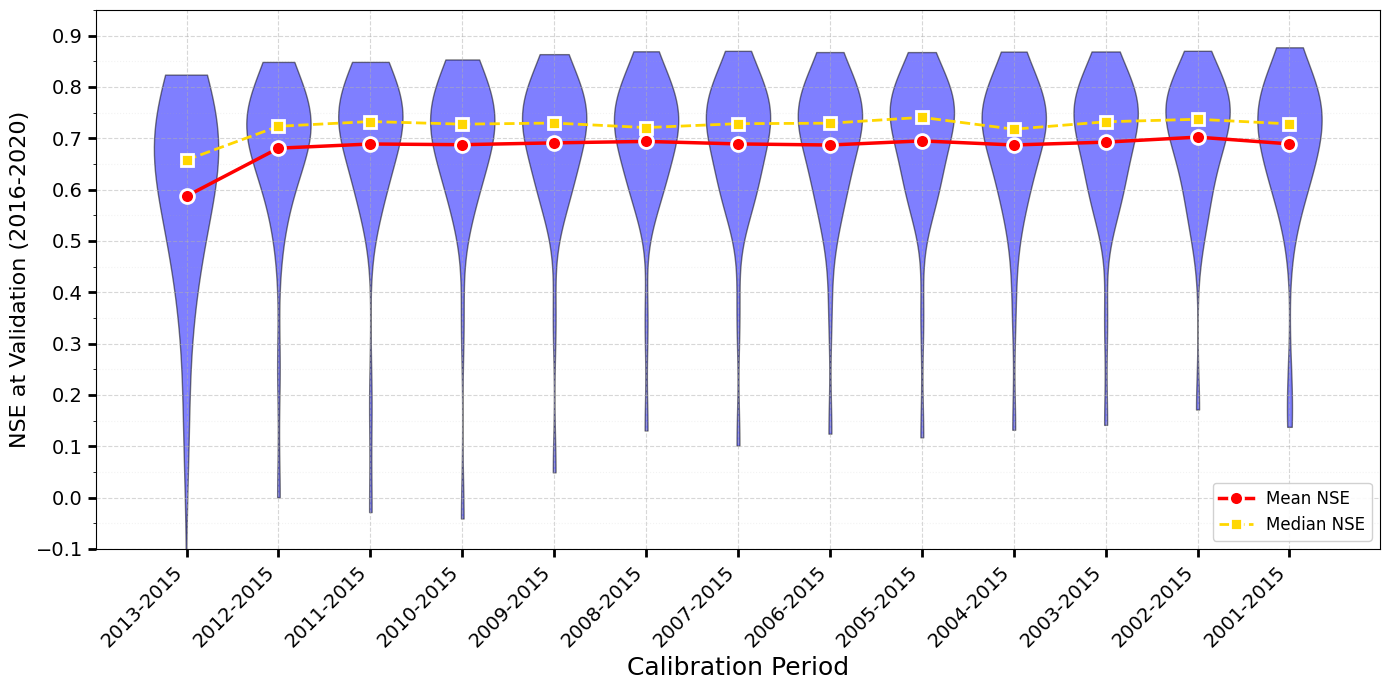


✓ Plot saved to Google Drive
✓ Displayed calibration periods: 3-15 years
✓ Period range: 2013-2015 to 2001-2015
✓ Total periods shown: 13


In [ ]:
"""
Violin Plot with Mean and Median Overlays
Starting from 3 years of calibration
With period labels on x-axis
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ============================================
# FILTER DATA: Only keep n_years >= 3
# ============================================
MIN_CALIB_YEARS = 3

filtered_results = {k: v for k, v in all_results.items() if k >= MIN_CALIB_YEARS}

# ============================================
# DEFINE CALIBRATION PERIODS (Starting from 3 years)
# ============================================
calibration_periods = {
    3: "2013-2015",
    4: "2012-2015",
    5: "2011-2015",
    6: "2010-2015",
    7: "2009-2015",
    8: "2008-2015",
    9: "2007-2015",
    10: "2006-2015",
    11: "2005-2015",
    12: "2004-2015",
    13: "2003-2015",
    14: "2002-2015",
    15: "2001-2015"
}

# ============================================
# COMPUTE SUMMARY STATISTICS
# ============================================
summary_results = []

for n_years in sorted(filtered_results.keys()):
    results = filtered_results[n_years]
    nse_vals = [res['NSE_val'] for res in results.values() if np.isfinite(res['NSE_val'])]

    if len(nse_vals) > 0:
        summary_results.append({
            'n_years': n_years,
            'mean_NSE': np.mean(nse_vals),
            'median_NSE': np.median(nse_vals)
        })

summary_df = pd.DataFrame(summary_results)

# ============================================
# PREPARE VIOLIN PLOT DATA
# ============================================
violin_data = []
positions = []

for n_years in sorted(filtered_results.keys()):
    results = filtered_results[n_years]
    nse_vals = [res['NSE_val'] for res in results.values() if np.isfinite(res['NSE_val'])]

    if len(nse_vals) > 0:
        violin_data.append(nse_vals)
        positions.append(n_years)

# ============================================
# CREATE FIGURE
# ============================================
fig, ax = plt.subplots(figsize=(14, 7))

# Violin plot
parts = ax.violinplot(
    violin_data,
    positions=positions,
    widths=0.7,
    showmeans=False,
    showmedians=False,
    showextrema=False
)

# Style violins
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('black')
    pc.set_linewidth(1)

# Overlay mean NSE
ax.plot(
    summary_df['n_years'],
    summary_df['mean_NSE'],
    'o-',
    linewidth=2.5,
    markersize=10,
    color='red',
    label='Mean NSE',
    zorder=3,
    markeredgecolor='white',
    markeredgewidth=2
)

# Overlay median NSE
ax.plot(
    summary_df['n_years'],
    summary_df['median_NSE'],
    's--',
    linewidth=2,
    markersize=8,
    color='gold',
    label='Median NSE',
    zorder=3,
    markeredgecolor='white',
    markeredgewidth=2
)

# ============================================
# FORMATTING
# ============================================
ax.set_xlabel('Calibration Period', fontsize=18)
ax.set_ylabel('NSE at Validation (2016-2020)', fontsize=16)

# ============================================
# SET Y-AXIS GRID AT 0.1 INTERVALS
# ============================================
ax.yaxis.set_major_locator(MultipleLocator(0.1))  # Major ticks every 0.1
ax.yaxis.set_minor_locator(MultipleLocator(0.05))  # Minor ticks every 0.05
ax.grid(True, which='major', alpha=0.5, linestyle='--')  # Grid at major ticks
ax.grid(True, which='minor', alpha=0.15, linestyle=':')  # Finer grid at minor ticks

ax.legend(fontsize=12, loc='best', framealpha=0.9)

# Set x-ticks with period labels at 45° angle
ax.set_xticks(summary_df['n_years'])
ax.set_xticklabels(
    [calibration_periods[n] for n in summary_df['n_years']],
    rotation=45,
    ha='right',
    fontsize=14
)
ax.tick_params(axis='both', labelsize=14, length=6, width=2)

# Set y-axis limits
ax.set_ylim([-0.1, 0.95])

# ============================================
# SAVE AND DISPLAY
# ============================================
plt.tight_layout()
plt.savefig(f'{Path}/calibration_length_impact_RANDOM_seed{RANDOM_SEED}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to Google Drive")
print(f"✓ Displayed calibration periods: {MIN_CALIB_YEARS}-{max(filtered_results.keys())} years")
print(f"✓ Period range: {calibration_periods[MIN_CALIB_YEARS]} to {calibration_periods[max(filtered_results.keys())]}")
print(f"✓ Total periods shown: {len(summary_df)}")

---
## 11. Save Results

In [ ]:
"""
Save ALL Results to CSV - RANDOM Stations
Complete dataset with all stations, all periods, all parameters, and all metrics
"""

import csv

print("="*70)
print("SAVING ALL RESULTS TO CSV - RANDOM STATIONS")
print("="*70)

# ============================================
# SAVE COMPREHENSIVE CSV FILE
# ============================================
try:
    with open(f'{Path}/all_results_complete_RANDOM_seed{RANDOM_SEED}.csv', 'w', newline='') as f:
        writer = csv.writer(f)

        # Write header
        writer.writerow([
            'random_seed',
            'calibration_years',
            'calibration_start',
            'calibration_end',
            'validation_start',
            'validation_end',
            'station_id',
            'mu',
            'lambda',
            'Qs',
            'qs',
            'NSE_train',
            'NSE_val',
            'RMSE_val'
        ])

        # Define calibration periods
        calibration_configs_dict = [
            {3: ('2013-01-01', '2015-12-31')},
            {4: ('2012-01-01', '2015-12-31')},
            {5: ('2011-01-01', '2015-12-31')},
            {6: ('2010-01-01', '2015-12-31')},
            {7: ('2009-01-01', '2015-12-31')},
            {8: ('2008-01-01', '2015-12-31')},
            {9: ('2007-01-01', '2015-12-31')},
            {10: ('2006-01-01', '2015-12-31')},
            {11: ('2005-01-01', '2015-12-31')},
            {12: ('2004-01-01', '2015-12-31')},
            {13: ('2003-01-01', '2015-12-31')},
            {14: ('2002-01-01', '2015-12-31')},
            {15: ('2001-01-01', '2015-12-31')}
        ]

        period_lookup = {}
        for config in calibration_configs_dict:
            for years, dates in config.items():
                period_lookup[years] = dates

        val_start = '2016-01-01'
        val_end = '2020-12-31'

        # Write data
        row_count = 0
        for n_years in sorted(all_results.keys()):
            results = all_results[n_years]

            if n_years in period_lookup:
                cal_start, cal_end = period_lookup[n_years]
            else:
                cal_start, cal_end = 'Unknown', 'Unknown'

            for station_id, res in results.items():
                mu, lambda_, Qs, qs = res['params']

                writer.writerow([
                    RANDOM_SEED,
                    int(n_years),
                    cal_start,
                    cal_end,
                    val_start,
                    val_end,
                    str(station_id),
                    float(mu),
                    float(lambda_),
                    float(Qs),
                    float(qs),
                    float(res['NSE_train']),
                    float(res['NSE_val']),
                    float(res['RMSE_val'])
                ])
                row_count += 1

    print(f"✓ Complete results saved to all_results_complete_RANDOM_seed{RANDOM_SEED}.csv")
    print(f"  Total rows: {row_count}")

except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

# Save summary
try:
    with open(f'{Path}/calibration_length_summary_RANDOM_seed{RANDOM_SEED}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['random_seed', 'n_years', 'mean_NSE', 'std_NSE', 'median_NSE', 'min_NSE', 'max_NSE', 'n_stations'])

        for _, row in summary_df.iterrows():
            writer.writerow([
                RANDOM_SEED,
                int(row['n_years']),
                float(row['mean_NSE']),
                float(row['std_NSE']),
                float(row['median_NSE']),
                float(row['min_NSE']),
                float(row['max_NSE']),
                int(row['n_stations'])
            ])

    print(f"✓ Summary saved to calibration_length_summary_RANDOM_seed{RANDOM_SEED}.csv")
except Exception as e:
    print(f"❌ Error saving summary: {e}")

print(f"\n{'='*70}")
print("FILES SAVED")
print(f"{'='*70}")
print(f"Location: {Path}")
print(f"Random seed: {RANDOM_SEED}")
print("\nFiles:")
print(f"  1. all_results_complete_RANDOM_seed{RANDOM_SEED}.csv")
print(f"  2. calibration_length_summary_RANDOM_seed{RANDOM_SEED}.csv")
print(f"  3. calibration_length_impact_RANDOM_seed{RANDOM_SEED}.png")
print(f"  4. calibration_length_boxplot_RANDOM_seed{RANDOM_SEED}.png")
print(f"  5. ID_RANDOM_STATIONS_seed{RANDOM_SEED}.txt")

SAVING ALL RESULTS TO CSV - RANDOM STATIONS
✓ Complete results saved to all_results_complete_RANDOM_seed42.csv
  Total rows: 549
❌ Error saving summary: 'std_NSE'

FILES SAVED
Location: /content/drive/MyDrive/Colab Notebooks/Data
Random seed: 42

Files:
  1. all_results_complete_RANDOM_seed42.csv
  2. calibration_length_summary_RANDOM_seed42.csv
  3. calibration_length_impact_RANDOM_seed42.png
  4. calibration_length_boxplot_RANDOM_seed42.png
  5. ID_RANDOM_STATIONS_seed42.txt
